# 0. 뉴스 카테고리 다중 분류

뉴스 내용을 보고 그 뉴스의 카테고리가 무엇인지 파악하는 분류기를 만들어보자.

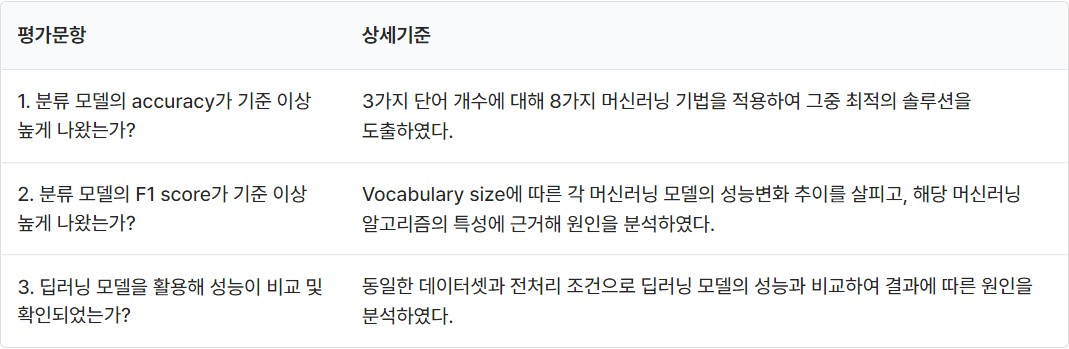

In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print(sys.version)
print(tf.__version__)

# !pip install tensorflow-addons==0.16.1
import tensorflow_addons.metrics

3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
2.6.0


In [3]:
tf.random.set_seed(9)
np.random.seed(9)

# 1. 데이터 확인하기

케라스에서 제공해주는 로이터 데이터를 불러온다.  
여기서 num_words는 단어 사전의 크기이다.

In [4]:
num_words = None
(train_X, train_y), (test_X, test_y) = reuters.load_data(num_words=num_words, test_split=0.2)


In [5]:
print('훈련 샘플의 수: {}'.format(len(train_X)))
print('테스트 샘플의 수: {}'.format(len(test_X)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [6]:
print(train_X[0])
print(test_X[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

특이하게도 text가 아닌 이미 토크나이징이 되어있다.  
조금 후에 원래 어떤 텍스트였는지 확인할 것이다.

In [7]:
print(train_y[0])
print(test_y[0])

3
3


target도 이미 정수로 토크나이징이 되어있다.  

In [8]:
print('레이블의 수 : {}'.format(max(train_y) + 1))

클래스의 수 : 46


레이블:  
'cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing', 'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton', 'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp', 'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal', 'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs', 'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver', 'wpi', 'hog', 'lead'

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


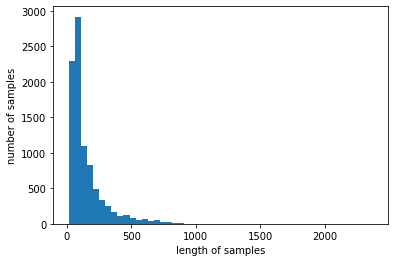

In [9]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(i) for i in train_X)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, train_X))/len(train_X)))

plt.hist([len(i) for i in train_X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장의 최대 길이는 2376(토큰)이지만 평균적으론 146(토큰)이다.

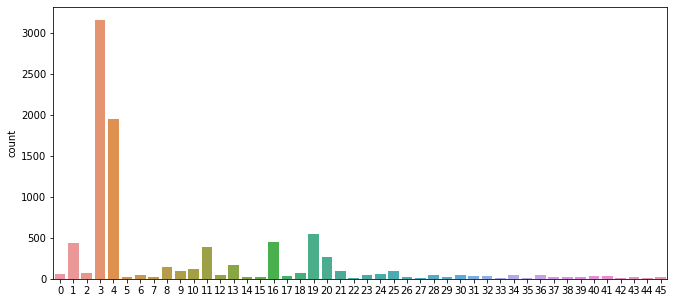

In [10]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=train_y)
plt.show()

In [11]:
print("각 레이블 빈도수:")
print(np.asarray((np.unique(train_y, return_counts=True))))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


3번과 4번 레이블에 데이터가 몰려있는 형태이다.  
이럴 때는 평가 지표를 Accuracy가 아닌 F1-Score를 써야한다.

# 2. 데이터 복원하기

데이터를 복원하기 위한 인덱스-워드 변환 사전을 만든다.  
워드-인덱스 사전은 로이터 패키지에 내장되어 있으므로 이것을 활용한다.  
참고로 토크나이징된 feature 데이터는 인덱스 1이 <sos> 토큰이지만  
내장돼있는 워드-인덱스 사전에서는 인덱스 1이 the 토큰이다.  
워드-인덱스 사전의 인덱스에 3씩 더해서 인덱스-워드 사전을 만들면 딱 맞아 떨어진다.

In [12]:
word_index = reuters.get_word_index()

In [13]:
index_word = {index+3: word for word, index in word_index.items()}

In [14]:
# index_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_word[index] = token

이제 드디어 원복된 텍스트를 살펴보자.

In [15]:
train_X = [' '.join([index_word[index] for index in train_X[i]])
                                           for i in range(len(train_X))]
print(len(train_X))
train_X[: 5]

8982


['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3",
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect th

In [16]:
test_X = [' '.join([index_word[index] for index in test_X[i]])
                                           for i in range(len(test_X))]
print(len(test_X))
test_X[: 5]

2246


['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

영어를 잘 못해서 무슨 뜻이지는 모르겠지만 문맥을 보니 잘 복원된 것으로 보인다.

# 3. 단어 빈도를 이용한 벡터화 하기

딥러닝에 최적화된 임베딩이 아닌  
단어 빈도를 이용한 머신러닝의 임베딩 및 벡터화 기법인  
DTM, TF-IDF를 이용해보자.  

DTM은 모든 문장들의 BoW 집합이라고 보면 된다.

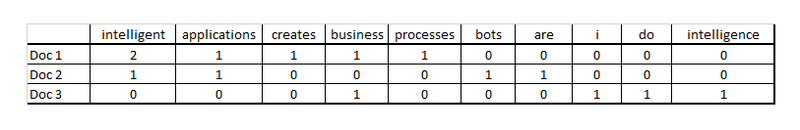

In [17]:
dtm_vectorizer = CountVectorizer()
train_X = dtm_vectorizer.fit_transform(train_X)
print(train_X.shape)

(8982, 26506)


In [18]:
test_X = dtm_vectorizer.transform(test_X) #테스트 데이터를 DTM으로 변환
print(test_X.shape)

(2246, 26506)


TF-IDF는 DTM에 가중치를 준 것이라고 보면 된다.  
그래서 shape는 서로 동일하다.

In [19]:
tfidf_transformer = TfidfTransformer()
train_X = tfidf_transformer.fit_transform(train_X)
print(train_X.shape)

(8982, 26506)


In [20]:
test_X = tfidf_transformer.transform(test_X) #DTM을 TF-IDF 행렬로 변환
print(test_X.shape)

(2246, 26506)


# 4. 다양한 머신러닝 모델 사용해보기

이제 바로 머신러닝 모델로 학습을 시켜보겠다.  
나이브 베이즈, 컴플리먼트 나이브 베이즈, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅  
이렇게 총 8가지 머신러닝 모델을 사용하겠다.

##  4.1. 나이브 베이즈 분류기

In [21]:
nb = MultinomialNB()
nb.fit(train_X, train_y)

nb_predicted = nb.predict(test_X)
nb_acc = accuracy_score(test_y, nb_predicted)
nb_report = classification_report(test_y, nb_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", nb_report['accuracy'])
print("F1-Score:", nb_report['weighted avg']['f1-score'])

정확도: 0.5997328584149599
F1-Score: 0.5045670886188423


##  4.2. 컴플리먼트 나이브 베이즈 분류기

In [22]:
cnb = ComplementNB()
cnb.fit(train_X, train_y)

cnb_predicted = cnb.predict(test_X)
cnb_acc = accuracy_score(test_y, cnb_predicted)
cnb_report = classification_report(test_y, cnb_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", cnb_report['accuracy'])
print("F1-Score:", cnb_report['weighted avg']['f1-score'])

정확도: 0.7649154051647373
F1-Score: 0.7346534179503126


##  4.3. 로지스틱 회귀

In [23]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

lr_predicted = lr.predict(test_X)
lr_acc = accuracy_score(test_y, lr_predicted)
lr_report = classification_report(test_y, lr_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", lr_report['accuracy'])
print("F1-Score:", lr_report['weighted avg']['f1-score'])

정확도: 0.7920747996438112
F1-Score: 0.7674140243009971


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##  4.4. 선형 서포트 벡터 머신

In [24]:
lsvc = SVC(kernel='linear', probability=True)
lsvc.fit(train_X, train_y)

lsvc_predicted = lsvc.predict(test_X)
lsvc_acc = accuracy_score(test_y, lsvc_predicted)
lsvc_report = classification_report(test_y, lsvc_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", lsvc_report['accuracy'])
print("F1-Score:", lsvc_report['weighted avg']['f1-score'])

정확도: 0.8227960819234195
F1-Score: 0.812281986294906


##  4.5. 결정 트리

In [25]:
tree = DecisionTreeClassifier()
tree.fit(train_X, train_y)

tree_predicted = tree.predict(test_X)
tree_acc = accuracy_score(test_y, tree_predicted)
tree_report = classification_report(test_y, tree_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", tree_report['accuracy'])
print("F1-Score:", tree_report['weighted avg']['f1-score'])

정확도: 0.707479964381122
F1-Score: 0.7016086471155489


##  4.6. 랜덤 포레스트

In [26]:
forest = RandomForestClassifier()
forest.fit(train_X, train_y)

forest_predicted = forest.predict(test_X)
forest_acc = accuracy_score(test_y, forest_predicted)
forest_report = classification_report(test_y, forest_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", forest_report['accuracy'])
print("F1-Score:", forest_report['weighted avg']['f1-score'])

정확도: 0.7377560106856634
F1-Score: 0.7107352322420252


##  4.7. 그래디언트 부스팅 트리

In [27]:
grbt = GradientBoostingClassifier() # verbose=3
grbt.fit(train_X, train_y)

grbt_predicted = grbt.predict(test_X)
grbt_acc = accuracy_score(test_y, grbt_predicted)
grbt_report = classification_report(test_y, grbt_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", grbt_report['accuracy'])
print("F1-Score:", grbt_report['weighted avg']['f1-score'])

정확도: 0.7658058771148709
F1-Score: 0.76207903895849


##  4.8. 보팅

In [28]:
voting = VotingClassifier(estimators=[
        ('lr', LogisticRegression()),
        ('lsvc', SVC(kernel='linear', probability=True)),
        ('grbt', GradientBoostingClassifier())
        ], voting='soft')
voting.fit(train_X, train_y)

voting_predicted = voting.predict(test_X)
voting_acc = accuracy_score(test_y, voting_predicted)
voting_report = classification_report(test_y, voting_predicted, output_dict=True,
                                  zero_division=0)

print("정확도:", voting_report['accuracy'])
print("F1-Score:", voting_report['weighted avg']['f1-score'])

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도: 0.8250222617987534
F1-Score: 0.8186890245107491


## 4.9. 모델 정확도, F1-Score 비교하기

In [29]:
table = pd.DataFrame(columns=['Accuracy', 'F1-Score'])
model_list = [nb, cnb, lr, lsvc, tree, forest, grbt, voting]

for model in model_list:
    predicted = model.predict(test_X)
    report = classification_report(test_y, predicted, output_dict=True,
                                  zero_division=0)
    model_name = model.__class__.__name__
    accuracy = report['accuracy']
    f1_score = report['weighted avg']['f1-score']
    table.loc[model_name] = [accuracy, f1_score]

table

,Accuracy,F1-Score
MultinomialNB,0.599733,0.504567
ComplementNB,0.764915,0.734653
LogisticRegression,0.792075,0.767414
SVC,0.822796,0.812282
DecisionTreeClassifier,0.707480,0.701609
RandomForestClassifier,0.737756,0.710735
GradientBoostingClassifier,0.765806,0.762079
VotingClassifier,0.825022,0.818689


평가 지표로 Accuracy와 F1-Score 둘 다 구해봤는데  
label별 데이터 수가 편향적일 때는 F1-Score를 보는 것이 낫다.

F1-Score 기준으로 VotingClassifier가 0.818689로 가장 높다.  
다만 Voting 모델은 여러 모델을 합친 앙상블 모델인데  
여기에는 Voting을 제외한 모델 중 가장 성능이 좋은 SVC 모델을 넣었기 때문에  
성능이 어느정도 보장이 된다.

# 5. Vocabulary Size를 변경해서 시도해보기

Vocabulary Size(num_words 변수)를 변경하고 머신러닝 모델을 돌려보면서  
성능이 어떻게 바뀌는지 살펴보자.

In [30]:
def all_in_one(num_words):
    (X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=num_words,
                                                             test_split=0.2)

    word_index = reuters.get_word_index(path="reuters_word_index.json")

    index_word = {index+3: word for word, index in word_index.items()}

    for i, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_word[i] = token

    X_train = [' '.join([index_word[index] for index in X_train[i]])
                                               for i in range(len(X_train))]

    X_test = [' '.join([index_word[index] for index in X_test[i]])
                                               for i in range(len(X_test))]

    dtm_vectorizer = CountVectorizer()
    X_train = dtm_vectorizer.fit_transform(X_train)
    X_test = dtm_vectorizer.transform(X_test)

    tfidf_transformer = TfidfTransformer()
    X_train = tfidf_transformer.fit_transform(X_train)
    X_test = tfidf_transformer.transform(X_test)

    nb = MultinomialNB()
    cnb = ComplementNB()
    lr = LogisticRegression()
    lsvc = SVC(kernel='linear', probability=True)
    tree = DecisionTreeClassifier()
    forest = RandomForestClassifier()
    grbt = GradientBoostingClassifier() # verbose=3
    voting = VotingClassifier(estimators=[
            ('lr', LogisticRegression()),
            ('lsvc', SVC(kernel='linear', probability=True)),
            ('grbt', GradientBoostingClassifier())
    ], voting='soft')

    table = pd.DataFrame(columns=['Accuracy', 'F1-Score'])
    model_list = [nb, cnb, lr, lsvc, tree, forest, grbt, voting]

    for model in model_list:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True,
                                      zero_division=0)
        model_name = model.__class__.__name__
        accuracy = report['accuracy']
        f1_score = report['weighted avg']['f1-score']
        table.loc[model_name] = [accuracy, f1_score]

    return table

In [47]:
num_words = 5000

table_5000 = all_in_one(num_words)

In [48]:
num_words = 10000

table_10000 = all_in_one(num_words)

In [55]:
pd.concat([table_5000, table_10000, table], axis=1)

,Accuracy,F1-Score,Accuracy,F1-Score,Accuracy,F1-Score
MultinomialNB,0.673197,0.601250,0.656723,0.576447,0.599733,0.504567
ComplementNB,0.770703,0.745899,0.770703,0.745668,0.764915,0.734653
LogisticRegression,0.797863,0.775961,0.795191,0.772794,0.792075,0.767414
SVC,0.825913,0.815529,0.821906,0.812059,0.822796,0.812282
DecisionTreeClassifier,0.691451,0.686799,0.694123,0.690177,0.707480,0.701609
RandomForestClassifier,0.764915,0.744264,0.759127,0.736414,0.737756,0.710735
GradientBoostingClassifier,0.766251,0.763303,0.767142,0.764180,0.765806,0.762079
VotingClassifier,0.821015,0.815287,0.827248,0.822163,0.825022,0.818689


위의 테이블은 왼쪽에서 부터 Vocabulary Size를  
5000으로 했을 때, 10000으로 했을 때, None(전부)로 했을 때의 Accuracy, F1_Score다.

그 결과 최종적으로 Vocabulary Size가 10000일 때의 VotingClassifier 모델의 성능이  
0.822163로 가장 높았다.  

단어 사전 크기가 클수록 성능이 좋아지는 모델이 있는 반면, 
오히려 떨어지는 모델도 있었다.  
Vocabulary Size가 적당한 것이 가장 좋은 것 같다.

# 6. 딥러닝 모델과 비교해 보기

이번엔 딥러닝의 임베딩(케라스 임베딩 레이어) + RNN을 이용해보자.  
가장 성능이 좋았던 단어사전크기 10000을 적용한다.

In [33]:
# int(26506 ** 0.54 * math.log(26506, 1+0.54))
num_words = 10000
(train_X_rnn, train_y_rnn), (test_X_rnn, test_y_rnn) = reuters.load_data(
                                        num_words=num_words, test_split=0.2)

너무 긴 문장까지 학습하면 패딩이 너무 많아지기 때문에 적당한 크기로 자른다.  
우선 평균 길이인 146보다는 커야할 것이다.(혹은 중위값 이상)

In [34]:
# point
train_X_rnn = tf.keras.preprocessing.sequence.pad_sequences(train_X_rnn,
              maxlen=2**8, padding='post', truncating='post')
test_X_rnn = tf.keras.preprocessing.sequence.pad_sequences(test_X_rnn,
              maxlen=2**8, padding='post', truncating='post')

일반적으로 소프트맥스의 출력값의 길이에 맞게 y값을 원핫 인코딩을 하지 않아도  
모델 컴파일링할 때 loss에 'sparse_categorical_crossentropy'를 지정해주면  
길이가 맞지 않아도 계산을 자동으로 해주지만  
평가 지표를 f1_score로 지정하려면 y값을 원핫 인코딩해줘야 한다.

In [35]:
train_y_rnn = tf.keras.utils.to_categorical(train_y_rnn)
test_y_rnn = tf.keras.utils.to_categorical(test_y_rnn)

In [36]:
def tsize(train_X):
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

tsize(train_X_rnn)

0.16

In [37]:
X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(train_X_rnn,
                    train_y_rnn, test_size=tsize(train_X_rnn))

간단한 lstm 모델을 만든다. 마지막 층인 Dense 레이어의 units 값에 레이블 개수를 넣고,  
활성화 함수로 softmax를 넣어줘야한다.

In [38]:
# point
class model_maker(tf.keras.Model):
    def __init__(self, num_words, output_dim):
        super().__init__()
        self.embedding1 = layers.Embedding(num_words, output_dim, input_shape=(None, ))
        self.lstm1 = layers.Bidirectional(layers.LSTM(output_dim // 2, return_sequences=True))
        self.drop1 = layers.Dropout(0.5)
        self.flatten2 = layers.Flatten()
        self.dense2 = layers.Dense(46, activation='softmax')
        
    def call(self, x):
        x = self.embedding1(x)
        x = self.lstm1(x)
        x = self.drop1(x)
        x = self.flatten2(x)
        x = self.dense2(x)
        
        return x


In [39]:
# point
output_dim = 2 ** 7

model = model_maker(num_words, output_dim)

케라스 평가 지표에는 f1_score가 없어서 tensorflow_addons.metrics  
패키지를 따로 설치해 줘야 한다.

In [40]:
print(sys.version)
print(tf.__version__)

# !pip install tensorflow-addons==0.16.1
# import tensorflow_addons.metrics

3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
2.6.0


원핫 인코딩된 y과 비교하기 때문에 loss에 categorical_crossentropy 넣고,  
metrics에 tensorflow_addons.metrics의 F1Score 메소드를 넣어준다.

In [41]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
                metrics=['accuracy',
                tensorflow_addons.metrics.F1Score(
                    num_classes=46, average='weighted')])

epochs = 2 ** 5

early_stop = EarlyStopping(patience=3)

history = model.fit(X_train_rnn,
                    y_train_rnn,
                    epochs=epochs,
                    batch_size=2**6, # point
                    validation_data=(X_val_rnn, y_val_rnn),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/32
118/118 [==============================] - 8s 27ms/step - loss: 1.6831 - accuracy: 0.5885 - f1_score: 0.5268 - val_loss: 1.1276 - val_accuracy: 0.7350 - val_f1_score: 0.6960
Epoch 2/32
118/118 [==============================] - 2s 21ms/step - loss: 0.7841 - accuracy: 0.8184 - f1_score: 0.7993 - val_loss: 0.9721 - val_accuracy: 0.7754 - val_f1_score: 0.7542
Epoch 3/32
118/118 [==============================] - 2s 21ms/step - loss: 0.4071 - accuracy: 0.9007 - f1_score: 0.8972 - val_loss: 1.0547 - val_accuracy: 0.7677 - val_f1_score: 0.7621
Epoch 4/32
118/118 [==============================] - 2s 21ms/step - loss: 0.2452 - accuracy: 0.9410 - f1_score: 0.9404 - val_loss: 1.1754 - val_accuracy: 0.7712 - val_f1_score: 0.7613
Epoch 5/32
118/118 [==============================] - 2s 21ms/step - loss: 0.2077 - accuracy: 0.9504 - f1_score: 0.9502 - val_loss: 1.1846 - val_accuracy: 0.7580 - val_f1_score: 0.7522


학습이 진행되는 과정을 시각화해보자.

In [42]:
def history_plot(history):
    keys = list(history.history.keys())
    values = list(history.history.values())
    
    plt.figure(figsize=(18, 6))
    
    for i in range(len(keys)//2):
        plt.subplot(1, len(keys)//2, i+1)
        plt.plot(range(len(values[0])), values[i], marker='.', label=keys[i])
        plt.plot(range(len(values[0])), values[i+3], marker='.', label=keys[i+3])
        plt.legend(loc='lower center')
        plt.grid()
        plt.title(f'{keys[i]} per epoch') 
        plt.xlabel('Epoch')
        plt.ylabel(keys[i])
    
    plt.show()

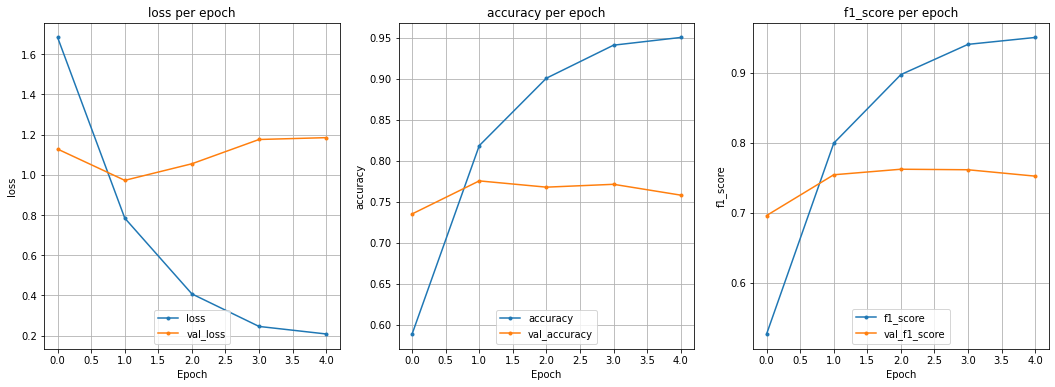

In [43]:
history_plot(history)

In [44]:
result = model.evaluate(test_X_rnn, test_y_rnn, verbose=1)

71/71 [==============================] - 1s 8ms/step - loss: 1.0842 - accuracy: 0.7774 - f1_score: 0.7681


딥러닝 모델의 f1_score는 0.7681으로 머신러닝 모델의 최대 f1_score인 0.822163보다 낮게 나왔다.  
어텐션 모델까지 쓴 다른 그루의 딥러닝 모델의 성능도 0.76 정도 되는 것을 봤는데  
도저히 답이 없어 보인다.

# 7. 회고하기

머신러닝 학습이 원래 이렇게 오래걸리는 건지 모르겠다.  
그래도 오래걸린 만큼 딥러닝보다 더 높은 성능을 보이긴 해서 할 말은 없다.  

머신러닝 모델 중에서도 가장 높은 성능을 보인 건 Voting이지만  
사실상 로지스틱 회귀 모델이 가장 성능이 높다고 볼 수 있다.  
회귀 모델은 딥러닝의 Dense 레이어 + softmax 활성화 함수와 같다고 볼 수 있다.  
역시 근본있는 모델 답게 성능이 잘 나와주었다.  
이전에도 왠만하면 회귀 모델의 성능이 가장 높게 나왔던 기억이 떠올랐다.  
근데 문제는 그 회귀 모델을 여러겹 겹친 모양인 딥러닝의 성능이 오히려 떨어졌다는 점이다.  
물론 어텐션, 트랜스포머 등의 모델을 매우 잘 만들면 어찌됐든 성능이 더 잘나올 것 같긴 하지만  
그래도 회귀 모델의 성능을 뛰어 넘을 거라고 보장은 못하겠다.  
참 귀신이 곡할 노릇이다.